In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *
torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0607_unigram'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['funniness_average'] = 0
test_df['funniness_average'].iloc[0] = 0.1
test_df['funniness_average'].iloc[1] = 1.2
test_df['funniness_average'].iloc[2] = 3.4
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='funniness_average')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_regr_bd_*.pth')]
len(model_wt_fnames)

41

In [8]:
!grep Reg ./prod/out_reg_tmp30.txt > ./by_seed_reg_perf

In [9]:
!head by_seed_reg_perf

Reg RndSeed: 161595,0.5545905828475952
Reg RndSeed: 63020,0.5519884824752808
Reg RndSeed: 560717,0.5355939865112305
Reg RndSeed: 190294,0.5400204062461853
Reg RndSeed: 162166,0.5507885813713074
Reg RndSeed: 575707,0.5656949281692505
Reg RndSeed: 490262,0.553819477558136
Reg RndSeed: 23520,0.5554379224777222
Reg RndSeed: 300047,0.5530928373336792
Reg RndSeed: 582688,0.5596522092819214


In [10]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_reg_perf', names = ['id','mse'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf.head()

,id,mse,rnd_seed
0,Reg RndSeed: 161595,0.554591,161595
1,Reg RndSeed: 63020,0.551988,63020
2,Reg RndSeed: 560717,0.535594,560717
3,Reg RndSeed: 190294,0.540020,190294
4,Reg RndSeed: 162166,0.550789,162166


Text(0.5, 1.0, 'Freq of mse over all Random Seeds (41) \n Vert line = 25th p-tile')

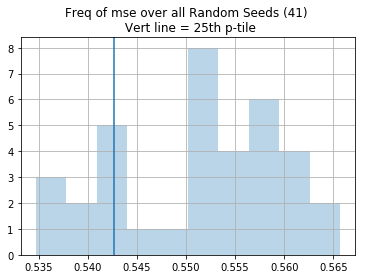

In [13]:
valid_perf.mse.hist(alpha=0.3)
plt.axvline(x=valid_perf.mse.quantile(0.25))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of mse over all Random Seeds (41) \n Vert line = 25th p-tile')

In [14]:
selected_rnd_seeds = valid_perf[valid_perf.mse <= valid_perf.mse.quantile(0.25)].rnd_seed.tolist()

In [15]:
model_wt_fnames = [f'haha_regr_bd_{x}.pth' for x in selected_rnd_seeds]

In [16]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [17]:
np.array(ensemble_preds).shape

(9, 6000, 1)

In [18]:
np.array(ensemble_preds)

array([[[ 1.496005e+00],
        [ 8.211528e-02],
        [ 2.302275e+00],
        [ 1.470998e-01],
        ...,
        [ 5.418284e-01],
        [ 1.058228e-01],
        [ 1.611913e+00],
        [ 1.593304e+00]],

       [[ 1.430603e+00],
        [ 1.912462e-02],
        [ 2.398391e+00],
        [ 1.662979e-01],
        ...,
        [ 9.906439e-01],
        [ 4.869458e-02],
        [ 1.603015e+00],
        [ 1.257795e+00]],

       [[ 1.369085e+00],
        [ 1.664697e-01],
        [ 2.122475e+00],
        [ 2.478340e-01],
        ...,
        [ 6.762975e-01],
        [ 2.843121e-02],
        [ 1.514012e+00],
        [ 1.545161e+00]],

       [[ 1.781014e+00],
        [-1.064091e-01],
        [ 2.324788e+00],
        [ 1.188383e-01],
        ...,
        [ 4.033855e-01],
        [-3.564858e-02],
        [ 1.365134e+00],
        [ 1.327381e+00]],

       ...,

       [[ 1.557089e+00],
        [ 6.851694e-02],
        [ 2.296907e+00],
        [ 2.651603e-01],
        ...,
        [ 9.13

In [19]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[1.44696 ],
       [0.024108],
       [2.296632],
       [0.190529],
       ...,
       [0.716726],
       [0.063109],
       [1.469768],
       [1.32079 ]], dtype=float32)

In [24]:
pd.DataFrame(ens_mean).to_csv('sub0608_unigram_mse_quantile_1.csv',header=True,index=False)

In [20]:
out_df = pd.read_csv('./data/submission/sub0523_1.csv')
out_df.head()

FileNotFoundError: File b'./data/submission/sub0523_1.csv' does not exist

In [28]:
out_df.shape, ens_mean.shape

((6000, 3), (6000, 1))

In [29]:
out_df.funniness_average = ens_mean

In [33]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,1.522744
1,tweet2,0,0.351772
2,tweet3,1,2.398724
3,tweet4,0,0.138691
4,tweet5,0,0.021646


In [30]:
out_df.to_csv('sub0601_1.csv',header=True,index=False)

In [31]:
!zip  sub0601_1.zip sub0601_1.csv 

  adding: sub0601_1.csv (deflated 67%)


In [32]:
!cp sub0601_1.zip /mnt/awcnas4_AWX/tmp/